<a href="https://colab.research.google.com/github/alessandrotofani/Tesi_magistrale/blob/master/7_SHAP_Fed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import drive
drive.mount('/content/drive')
from sklearn.model_selection import train_test_split

Mounted at /content/drive


In [2]:
!pip install --quiet fastai==2.2.5

     |████████████████████████████████| 194kB 16.5MB/s 
     |████████████████████████████████| 61kB 8.1MB/s 


In [3]:
import sys 
sys.path.append('/content/drive/MyDrive/Tesi_magistrale/Tesi_magistrale')
import mf
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Dataset import

In [4]:
data = pd.read_csv('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/data.csv')
data = mf.new_processing(data)
data = pd.get_dummies(data)
feature_names = mf.get_col(data)

# Model import

## XGBoost

In [5]:
categorical_features = np.arange(178,1091).tolist()

In [6]:
pd.options.mode.chained_assignment = None
X_test = mf.get_set('test_id', data, 'MLP')

**Importante**: se il modello è trainato su GPU, quando si carica bisogna attivare il runtime con GPU, sennò il modello non vine caricato nel modo corretto. 

In [7]:
load = True
if load:
  from tensorflow import keras
  model = keras.models.load_model('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/MLP/fed_mlp')

Issue: https://github.com/slundberg/shap/issues/452

Vedere https://github.com/dmlc/xgboost/blob/master/demo/gpu_acceleration/shap.ipynb

In [8]:
# booster = xgb.get_booster()
# booster.predict(X_test.to_numpy(), pred_contribs = True, validate_features=False)

# SHAP

**Idea**

A prediction can be explained by assuming that each feature value of the instance is a “player” in a game where the prediction is the payout. Shapley values – a method from coalitional game theory – tells us how to fairly distribute the “payout” among the features.

**Definition**

The Shapley value is the average marginal contribution of a feature value across all possible coalitions. 

The Shapley value is NOT the difference in prediction when we would remove the feature from the model. 

**Interpretation**

Given the current set of feature values, the contribution of a feature value to the difference between the actual prediction and the mean prediction is the estimated Shapley value.

**Theoretical algorithm**

Per determinare il valore di Shapley della feature x_j, si elimina la feature dal dataset, e delle altre si fanno tutte le possibili estrazioni, andando a fare la predizione solo con le feature selezionate e aggiungendo x_j. Facendo la differenza tra ogni predizione con e senza x_j si ottiene il contributo marginale di x_j. 
Per fare la predizione con il modello quando delle feature sono state eliminate, si rimpiazzano i loro valori con valori random (ovviamente tra quelli delle feature rimosse) estratti dal dataset. 


**Implementation**

SHAP turns the Shapley values method into an optimization problem and uses a special kernel function to measure proximity of data instances. The results of SHAP are sparse

**Riferimenti**

Repo github: https://github.com/slundberg/shap

Tutorial (vedere parte per RF): https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a

Grafici con codice funzionante: https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Census%20income%20classification%20with%20LightGBM.html?highlight=classification



In [9]:
!pip install --quiet shap

     |████████████████████████████████| 358kB 13.1MB/s 


In [10]:
import shap
shap.initjs()

explainer = shap.KernelExplainer(model.predict, shap.sample(X_test.to_numpy(), 40))

In [11]:
X_test

TransactionDT  TransactionAmt  ...  browser_name_silk  browser_name_waterfox
174364       0.235124        0.002018  ...                  0                      0
418646       0.668431        0.001213  ...                  0                      0
280748       0.428839        0.001349  ...                  0                      0
582196       0.983185        0.003656  ...                  0                      0
420118       0.670400        0.001411  ...                  0                      0
...               ...             ...  ...                ...                    ...
257079       0.385830        0.000536  ...                  0                      0
396902       0.630514        0.001494  ...                  0                      0
473265       0.772798        0.001840  ...                  0                      0
152944       0.196282        0.001389  ...                  0                      0
425280       0.679280        0.006662  ...                  0                      0

[118107 rows x 733 columns]

In [12]:
predictions = model.predict(X_test[:100])

In [13]:
indici = [i for i,x in enumerate(predictions) if x>0.5]

In [14]:
lista = np.arange(100,120).tolist()
x = X_test.iloc[indici].to_numpy()
y = X_test.iloc[lista].to_numpy()
z = np.concatenate((x,y), axis=0)
kernel_shap = explainer.shap_values(z)[0] #sono i valori di shapley
# kernel_shap[1].shape

In [118]:
def get_highest_shap_values(kernel_shap, id, feature_names, x):
  import operator
  first_shap = kernel_shap[id,:]
  values = {}
  shap_values = {}
  for val in first_shap:
    # if val != 0:
    col_index = first_shap.tolist().index(val)
    values[feature_names[col_index]] = x[id][col_index]
    shap_values[feature_names[col_index]] = val

  sorted_d = dict(sorted(shap_values.items(), key=operator.itemgetter(1), reverse=True))
  # return shap_values, values
  return sorted_d, shap_values, values

def print_shap(sorted_shap_values, values, top_values = 10):
  i = 0
  n = len(sorted_shap_values)
  for col in sorted_shap_values:
    if i <= top_values:
      print(col, 'with value', values[col], 'has shap value', sorted_shap_values[col])
    if i >= n - top_values and sorted_shap_values[col]<0:
      print(col, 'with value', values[col], 'has shap value', sorted_shap_values[col])
    i+=1
  return 

# print_shap(sorted_shap_values, values)

In [120]:
kernel_shap[0,:]

array([ 0.        ,  0.        ,  0.00303878,  0.01860118,  0.03071403,
        0.        ,  0.        ,  0.        ,  0.01460076,  0.03400762,
        0.        ,  0.00282794,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.00864904,  0.        ,  0.0136452 ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.00228677,  0.        ,  0.        ,
        0.        ,  0.        ,  0.00479515,  0.00088885,  0.        ,
        0.        ,  0.        ,  0.000977  ,  0.        ,  0.        ,
        0.00016005,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.00197458,  0.        ,
        0.        ,  0.        ,  0.0088114 ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.00

In [119]:
all_sorted = []
all_values = []

for id in range(len(kernel_shap)):
  sorted_shap_values, shap_values, values = get_highest_shap_values(kernel_shap, id, feature_names, x)
  all_sorted.append(sorted_shap_values)
  all_values.append(values)

IndexError: ignored

In [ ]:
dict_data = {}
datas = []
for id in len(kernel_shap):
  for col in all_sorted[id]:
    tmp = []
    tmp.append(all_values[id][col])
    tmp.append(all_sorted[id][col])
  dict_data[id] = tmp
for id in dict_data:
  datas.append(dict_data[id])
datas

In [ ]:
a1 = []
a2 = []
for col in sorted_shap_values:
  for i in range(2):
    a1.append(col)
for i in range(len(a1)):
  if i%2 == 0:
    a2.append('value')
  else:
    a2.append('shap_value')
arrays = [a1,a2]
tuples = list(zip(*arrays))
index = pd.MultiIndex.from_tuples(tuples, names=["Feature", "Values"])

In [ ]:
df = pd.DataFrame(data=datas, index=[n for n in len(kernel_shap)], columns=index)

In [102]:
datas = []
for col in sorted_shap_values:
  datas.append(values[col])
  datas.append(sorted_shap_values[col])
datas = [datas]

In [103]:
a1 = []
a2 = []
for col in sorted_shap_values:
  for i in range(2):
    a1.append(col)
for i in range(len(a1)):
  if i%2 == 0:
    a2.append('value')
  else:
    a2.append('shap_value')
arrays = [a1,a2]
tuples = list(zip(*arrays))
index = pd.MultiIndex.from_tuples(tuples, names=["Feature", "Values"])

In [104]:
df = pd.DataFrame(data=datas, index=['1'], columns=index)

In [105]:
df

Feature R_emaildomain_gmail.com             ... id_15_Found           
Values                    value shap_value  ...       value shap_value
1                           1.0   0.125863  ...         1.0  -0.107057

[1 rows x 138 columns]

In [41]:
shap.initjs()
shap.force_plot(explainer.expected_value, kernel_shap[0,:], feature_names=feature_names)

In [42]:
shap.initjs()
shap.force_plot(explainer.expected_value, kernel_shap[1,:], feature_names=feature_names)

In [43]:
shap.initjs()
shap.force_plot(explainer.expected_value, kernel_shap[2,:], feature_names=feature_names)

In [44]:
shap.initjs()
shap.force_plot(explainer.expected_value, kernel_shap[3,:], feature_names=feature_names)

In [45]:
shap.initjs()
shap.force_plot(explainer.expected_value, kernel_shap[8,:], feature_names=feature_names)

In [46]:
shap.initjs()
shap.force_plot(explainer.expected_value, kernel_shap[12,:], feature_names=feature_names)

In [47]:
shap.initjs()
shap.force_plot(explainer.expected_value, kernel_shap[13,:], feature_names=feature_names)

In [48]:
shap.initjs()
shap.force_plot(explainer.expected_value, kernel_shap[14,:], feature_names=feature_names)

In [49]:
shap.initjs()
shap.force_plot(explainer.expected_value, kernel_shap[15,:], feature_names=feature_names)

In [50]:
shap.initjs()
shap.force_plot(explainer.expected_value, kernel_shap[16,:], feature_names=feature_names)

In [51]:
shap.initjs()
shap.force_plot(explainer.expected_value, kernel_shap[18,:], feature_names=feature_names)

In [52]:
shap.initjs()
shap.force_plot(explainer.expected_value, kernel_shap[19,:], feature_names=feature_names)

In [53]:
shap.initjs()
shap.force_plot(explainer.expected_value, kernel_shap, feature_names=feature_names)

Decision plot: https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/decision_plot.html?highlight=plot

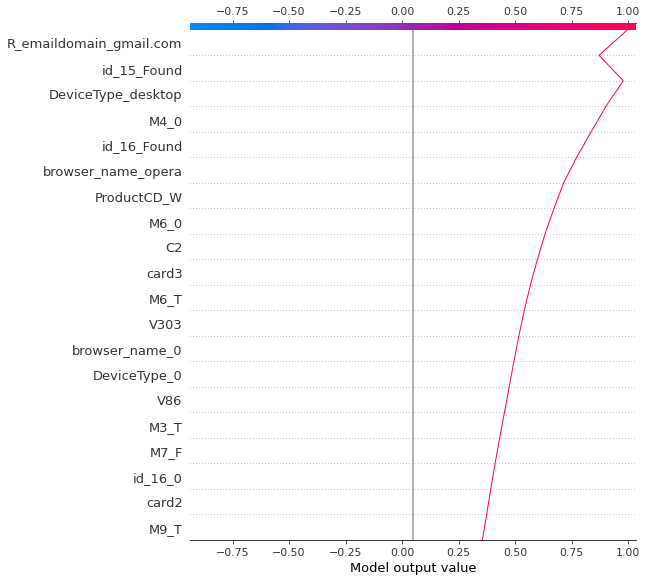

In [54]:
shap.decision_plot(explainer.expected_value, kernel_shap[0,:], feature_names=feature_names)

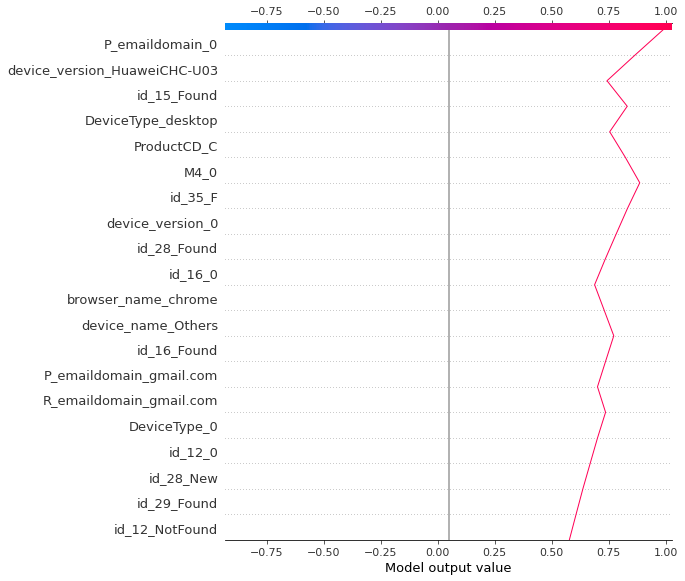

In [55]:
shap.decision_plot(explainer.expected_value, kernel_shap[1,:], feature_names=feature_names)

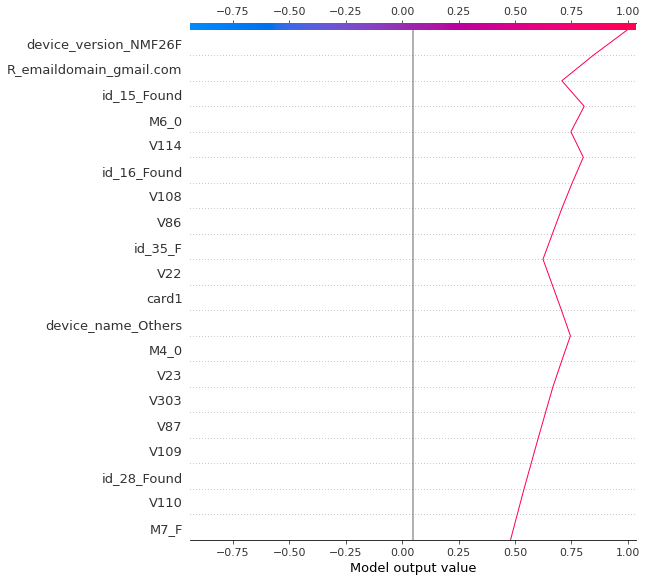

In [56]:
shap.decision_plot(explainer.expected_value, kernel_shap[2,:], feature_names=feature_names)

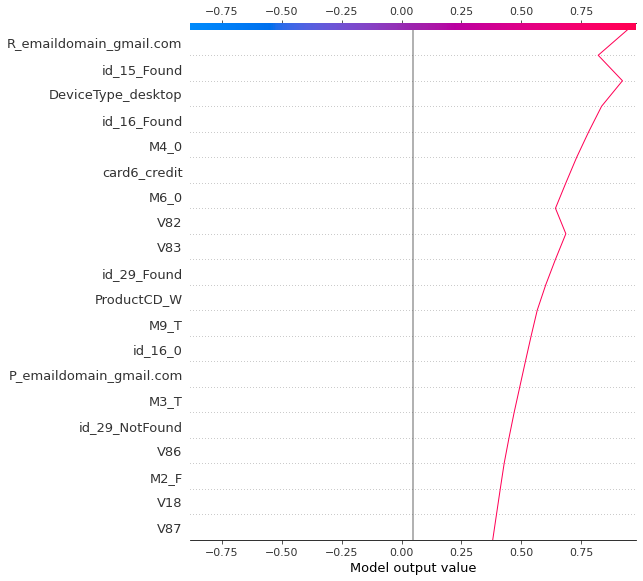

In [57]:
shap.decision_plot(explainer.expected_value, kernel_shap[3,:], feature_names=feature_names)

In [58]:
summary = np.asmatrix(kernel_shap)

In [59]:
summary

matrix([[ 0.        ,  0.        ,  0.00303878, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.01488825,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.01026953, -0.04086047, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [-0.00483546,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.00385907,  0.00263354, -0.02179737, ...,  0.        ,
          0.        ,  0.        ],
        [-0.0480839 ,  0.        , -0.00279809, ...,  0.        ,
          0.        ,  0.        ]])

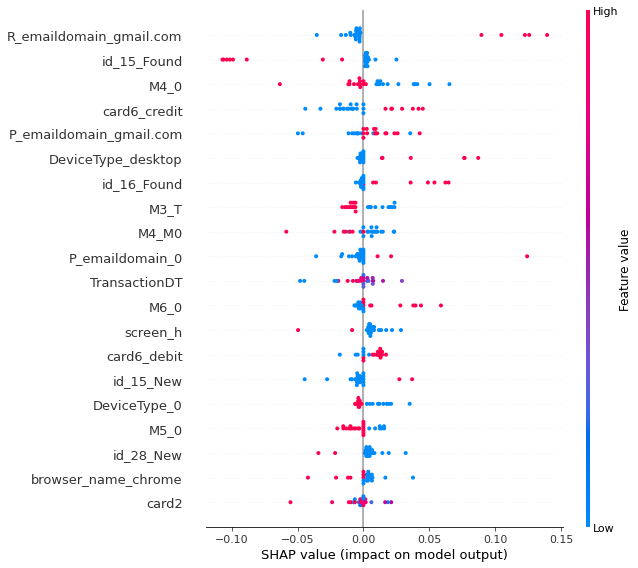

In [60]:
shap.summary_plot(kernel_shap, z, feature_names=feature_names)